# SPRINT 2

The aim of sprint 2 is to get to sharpen EDA, preprocess data, feature engineering start working with basic models.

This notbook is divided in the following sections:

- Load data and optimize it for model training (same as sprint 1)
- Experiments

My goal here is to find a basic pipeline that raises the performance (with recall metric at 70%) above the research on CICIOT by customizing the models around one kind of attack.


## Load data and process it

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

### Extracting the relevant data from csv files


Now, we know from previous exploration that we have 34 labels. For EDA purposes we should remap them in 5 kinds:

- Benign Traffic
- DDoS attacks
- DoS attacks
- Mirai attacks
- Spoofing attacks
- Web attacks
- Brute Force attacks
- Recon attacks

The following table breaks down the categories:

| Attack Category    | Attack Objective                                  | Entry Points                | Expected Network Traffic Change |
|--------------------|---------------------------------------------------|-----------------------------|---------------------------------|
| Benign Traffic     | Normal network operations                         | Various                     | No significant change          |
| DDoS Attacks       | Disrupt service by overwhelming resources         | Network interfaces          | Significant increase           |
| DoS Attacks        | Disrupt service to a server or network            | Network interfaces          | Sudden spike or drop           |
| Mirai Attacks      | Exploit IoT devices for large-scale attacks       | IoT devices                 | Varied, often increased        |
| Spoofing Attacks   | Impersonate devices or users                      | Network interfaces, devices | Varied, potential increase     |
| Web Attacks        | Exploit web services vulnerabilities              | Web servers, applications   | Varied, often targeted         |
| Brute Force Attacks| Crack passwords through trial and error          | Authentication systems      | Varied, often increased        |
| Recon Attacks      | Gather information about network and vulnerabilities | Network scanning, probing | Minor, but patterned increase  |


We know from the litterature on the dataset that previous modelling attempts were very good at detecting DDoS and DoS attacks.

This is why we focus on Recon attacks.

To do so we have to extract relevant data from the 126 .csv files and create a single data frame.

Let's first take a sample from these:

In [2]:
# Creating list of csv files 
directory = r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023"
csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

# Taking one sample
sample_df = pd.read_csv(r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023\part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
sample_df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

Now we have to make sure the data types will stay the same while we append each chunk to the combined data frame.

In [3]:
# Create dictionary with column and data type
d_types = {k: v.name for k, v in zip(sample_df.columns,sample_df.dtypes)}

d_types

{'flow_duration': 'float64',
 'Header_Length': 'float64',
 'Protocol Type': 'float64',
 'Duration': 'float64',
 'Rate': 'float64',
 'Srate': 'float64',
 'Drate': 'float64',
 'fin_flag_number': 'float64',
 'syn_flag_number': 'float64',
 'rst_flag_number': 'float64',
 'psh_flag_number': 'float64',
 'ack_flag_number': 'float64',
 'ece_flag_number': 'float64',
 'cwr_flag_number': 'float64',
 'ack_count': 'float64',
 'syn_count': 'float64',
 'fin_count': 'float64',
 'urg_count': 'float64',
 'rst_count': 'float64',
 'HTTP': 'float64',
 'HTTPS': 'float64',
 'DNS': 'float64',
 'Telnet': 'float64',
 'SMTP': 'float64',
 'SSH': 'float64',
 'IRC': 'float64',
 'TCP': 'float64',
 'UDP': 'float64',
 'DHCP': 'float64',
 'ARP': 'float64',
 'ICMP': 'float64',
 'IPv': 'float64',
 'LLC': 'float64',
 'Tot sum': 'float64',
 'Min': 'float64',
 'Max': 'float64',
 'AVG': 'float64',
 'Std': 'float64',
 'Tot size': 'float64',
 'IAT': 'float64',
 'Number': 'float64',
 'Magnitue': 'float64',
 'Radius': 'float64',


Now let's use this data type read each csv. Subsequently we will filter on the labels that we need: those whith benign traffic and those with the 5 kinds of recon attacks.

In [4]:
# Initialize empty df
combined_df = pd.DataFrame()


# List the labels that we need from each csv file
labels_select = ['Recon-PingSweep', 'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan', 'Recon-HostDiscovery', 'BenignTraffic']

# Loop over the list of csv file
for file_path in csv_files:
    df = pd.read_csv(file_path, dtype=d_types, low_memory=False) # read the data with d_types

    # Filter based on the selected labels
    filtered_df = df[df['label'].isin(labels_select)]

    # append to combined_df
    combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)



In [5]:
# Check the result
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452760 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452760 non-null  float64
 1   Header_Length    1452760 non-null  float64
 2   Protocol Type    1452760 non-null  float64
 3   Duration         1452760 non-null  float64
 4   Rate             1452760 non-null  float64
 5   Srate            1452760 non-null  float64
 6   Drate            1452760 non-null  float64
 7   fin_flag_number  1452760 non-null  float64
 8   syn_flag_number  1452760 non-null  float64
 9   rst_flag_number  1452760 non-null  float64
 10  psh_flag_number  1452760 non-null  float64
 11  ack_flag_number  1452760 non-null  float64
 12  ece_flag_number  1452760 non-null  float64
 13  cwr_flag_number  1452760 non-null  float64
 14  ack_count        1452760 non-null  float64
 15  syn_count        1452760 non-null  float64
 16  fin_count        1

In [6]:
# Check shape
combined_df.shape[0]

1452760

In [7]:
# Check NAs, we expect 0
combined_df.isna().sum()

flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64

In [8]:
# Check for duplicates (we expect very few)
combined_df.duplicated().sum()

5

In [9]:
# Remove duplicates: df
df = combined_df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(1452755, 47)

In [12]:
# Clear memory
del combined_df
del sample_df

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452755 non-null  float64
 1   Header_Length    1452755 non-null  float64
 2   Protocol Type    1452755 non-null  float64
 3   Duration         1452755 non-null  float64
 4   Rate             1452755 non-null  float64
 5   Srate            1452755 non-null  float64
 6   Drate            1452755 non-null  float64
 7   fin_flag_number  1452755 non-null  float64
 8   syn_flag_number  1452755 non-null  float64
 9   rst_flag_number  1452755 non-null  float64
 10  psh_flag_number  1452755 non-null  float64
 11  ack_flag_number  1452755 non-null  float64
 12  ece_flag_number  1452755 non-null  float64
 13  cwr_flag_number  1452755 non-null  float64
 14  ack_count        1452755 non-null  float64
 15  syn_count        1452755 non-null  float64
 16  fin_count        145275

Now let's change the data types for better efficiency

In [14]:
dtypes = {
        'flow_duration': np.float32,
        'Header_Length': np.uint32,
        'Protocol Type': str,
        'Duration': np.float32,
        'Rate': np.uint32,
        'Srate': np.uint32,
        'Drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'HTTP': np.bool_, 
        'HTTPS': np.bool_, 
        'DNS': np.bool_, 
        'Telnet': np.bool_,
        'SMTP': np.bool_, 
        'SSH': np.bool_, 
        'IRC': np.bool_, 
        'TCP': np.bool_, 
        'UDP': np.bool_, 
        'DHCP': np.bool_, 
        'ARP': np.bool_, 
        'ICMP': np.bool_, 
        'IPv': np.bool_, 
        'LLC': np.bool_,
        'Tot sum': np.float32, 
        'Min': np.float32, 
        'Max': np.float32, 
        'AVG': np.float32, 
        'Std': np.float32, 
        'Tot size': np.float32, 
        'IAT': np.float32, 
        'Number': np.float32,
        'Magnitue': np.float32, 
        'Radius': np.float32, 
        'Covariance': np.float32, 
        'Variance': np.float32, 
        'Weight': np.float32, 
        'label': str
    }

# Define function to change data type and adjust formatting

def convert_dtype(df):
    # Adjust data type
    for col,typ in dtypes.items():
        df[col] = df[col].astype(typ)   
    
    # Format column names to lowercase snake
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Fix spelling error in original dataset
    df['magnitude'] = df['magnitue']
    return df.drop(['magnitue'], axis=1)


# call the function
convert_dtype(df)

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,radius,covariance,variance,weight,label,magnitude
0,37.887028,1687747,9.3,63.500000,34,34,0.0,False,False,False,...,332.122437,817.500000,5.235219e-03,5.5,469.692078,2.092362e+05,0.9,38.500000,BenignTraffic,24.333355
1,48.272385,128041,10.4,97.800003,39966,39966,0.0,False,False,False,...,694.907043,636.400024,1.665200e+08,13.5,983.968323,4.842123e+05,1.0,244.600006,BenignTraffic,36.393288
2,48.095661,101026,8.8,137.699997,13,13,0.0,False,False,False,...,1302.117188,919.299988,2.724581e-02,5.5,1841.471802,2.063959e+06,0.9,38.500000,BenignTraffic,47.214172
3,46.342407,1301464,4.8,168.300003,34,34,0.0,False,False,False,...,0.428562,64.800003,3.804951e-02,5.5,0.606078,9.315556e-01,0.2,38.500000,BenignTraffic,11.472816
4,88.807747,5290348,7.1,63.599998,61,61,0.0,False,False,False,...,101.938538,1227.300049,1.833391e-03,5.5,144.162857,5.276998e+04,0.2,38.500000,BenignTraffic,54.184532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452755,0.732928,2250732,6.0,93.500000,2782,2782,0.0,False,False,False,...,836.076416,917.599976,8.809566e-05,5.5,1182.390625,8.859554e+05,0.8,38.500000,BenignTraffic,38.208549
1452756,13.401717,11497,6.0,59.200001,11,11,0.0,False,False,False,...,64.519730,108.199997,9.288311e-03,5.5,91.244675,4.696484e+03,0.9,38.500000,BenignTraffic,14.697835
1452757,9.528511,116067,12.6,82.699997,17,17,0.0,False,False,False,...,187.924698,337.500000,1.846900e-02,5.5,265.765656,6.190794e+04,0.9,38.500000,BenignTraffic,19.810381
1452758,16.250675,85094,8.8,103.400002,15,15,0.0,False,False,False,...,857.873474,105.800003,1.665168e+08,13.5,1215.209839,7.409860e+05,1.0,244.600006,BenignTraffic,34.988182


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 48 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452755 non-null  float32
 1   header_length    1452755 non-null  uint32 
 2   protocol_type    1452755 non-null  object 
 3   duration         1452755 non-null  float32
 4   rate             1452755 non-null  uint32 
 5   srate            1452755 non-null  uint32 
 6   drate            1452755 non-null  float32
 7   fin_flag_number  1452755 non-null  bool   
 8   syn_flag_number  1452755 non-null  bool   
 9   rst_flag_number  1452755 non-null  bool   
 10  psh_flag_number  1452755 non-null  bool   
 11  ack_flag_number  1452755 non-null  bool   
 12  ece_flag_number  1452755 non-null  bool   
 13  cwr_flag_number  1452755 non-null  bool   
 14  ack_count        1452755 non-null  float16
 15  syn_count        1452755 non-null  float16
 16  fin_count        145275

In order to perform EDA we need change protocol types in a format that is human readable. Right now they are a float indicating the protocol type. We will turn that into an integer and apply a mapping with the description of the protocol type using IANA (Internet Assigned Numbers Authority) protocol numbers.

In [16]:
# Map IANA Protocol numbers to strings (leave user option to 1-hot or numerically encode)
iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}

# transform the column protocol type

df['protocol_type'] = df['protocol_type'].apply(lambda x: iana_map[str(int(float(x)))])

set(df['protocol_type'])

{'ARGUS (deprecated)',
 'BBN-RCC-MON',
 'CBT',
 'CHAOS',
 'EGP',
 'EMCON',
 'GGP',
 'HOPOPT',
 'ICMP',
 'IGMP',
 'IGP',
 'IPv4',
 'NVP-II',
 'PUP',
 'ST',
 'TCP',
 'UDP',
 'XNET'}

In [17]:
def is_recon(x):
    if x == 'BenignTraffic':
        return 'BenignTraffic'
    else:
        return 'ReconAttack'

df['label_red'] = df['label'].map(is_recon)

In [18]:
set(df['label_red'])

{'BenignTraffic', 'ReconAttack'}

In [27]:
# Hot encoded label_red
df['label_red_bin'] = df['label_red'].map({'BenignTraffic': 0, 'ReconAttack': 1})
df['label_red_bin'].value_counts()

label_red_bin
0    1098195
1     354560
Name: count, dtype: int64

In [28]:
df = pd.get_dummies(df, columns=['protocol_type'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 67 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   flow_duration                     1452755 non-null  float32
 1   header_length                     1452755 non-null  uint32 
 2   duration                          1452755 non-null  float32
 3   rate                              1452755 non-null  uint32 
 4   srate                             1452755 non-null  uint32 
 5   drate                             1452755 non-null  float32
 6   fin_flag_number                   1452755 non-null  bool   
 7   syn_flag_number                   1452755 non-null  bool   
 8   rst_flag_number                   1452755 non-null  bool   
 9   psh_flag_number                   1452755 non-null  bool   
 10  ack_flag_number                   1452755 non-null  bool   
 11  ece_flag_number                   1452755 

In [30]:
# select numerical columns

df_numerical = df.select_dtypes(include=['bool','uint16','uint32','int64','float16','float32'])


### Final Checks


In [33]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 65 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   flow_duration                     1452755 non-null  float32
 1   header_length                     1452755 non-null  uint32 
 2   duration                          1452755 non-null  float32
 3   rate                              1452755 non-null  uint32 
 4   srate                             1452755 non-null  uint32 
 5   drate                             1452755 non-null  float32
 6   fin_flag_number                   1452755 non-null  bool   
 7   syn_flag_number                   1452755 non-null  bool   
 8   rst_flag_number                   1452755 non-null  bool   
 9   psh_flag_number                   1452755 non-null  bool   
 10  ack_flag_number                   1452755 non-null  bool   
 11  ece_flag_number                   1452755 

We need the full memory at work! let's delete the memory

In [34]:

#df.to_csv('cybersec_reworked.csv', index=False)
del df

Check again d_types

In [35]:
d_types = {k: v.name for k, v in zip(df_numerical.columns,df_numerical.dtypes)}

d_types

{'flow_duration': 'float32',
 'header_length': 'uint32',
 'duration': 'float32',
 'rate': 'uint32',
 'srate': 'uint32',
 'drate': 'float32',
 'fin_flag_number': 'bool',
 'syn_flag_number': 'bool',
 'rst_flag_number': 'bool',
 'psh_flag_number': 'bool',
 'ack_flag_number': 'bool',
 'ece_flag_number': 'bool',
 'cwr_flag_number': 'bool',
 'ack_count': 'float16',
 'syn_count': 'float16',
 'fin_count': 'uint16',
 'urg_count': 'uint16',
 'rst_count': 'uint16',
 'http': 'bool',
 'https': 'bool',
 'dns': 'bool',
 'telnet': 'bool',
 'smtp': 'bool',
 'ssh': 'bool',
 'irc': 'bool',
 'tcp': 'bool',
 'udp': 'bool',
 'dhcp': 'bool',
 'arp': 'bool',
 'icmp': 'bool',
 'ipv': 'bool',
 'llc': 'bool',
 'tot_sum': 'float32',
 'min': 'float32',
 'max': 'float32',
 'avg': 'float32',
 'std': 'float32',
 'tot_size': 'float32',
 'iat': 'float32',
 'number': 'float32',
 'magnitue': 'float32',
 'radius': 'float32',
 'covariance': 'float32',
 'variance': 'float32',
 'weight': 'float32',
 'magnitude': 'float32',
 

Ok now we can use df_numerical and save it with integers vs boolean to ensure data type consistency across platforms (say on google colab)

In [36]:
# Convert boolean columns to integers
bool_cols = df_numerical.select_dtypes(include=['bool']).columns
df_numerical[bool_cols] = df_numerical[bool_cols].astype(int) # CONVERTING TO INTEGERS IN ORDER TO AVOID CORRUPTION

# Save to CSV
#df_numerical.to_csv('df_numerical_modified.csv', index=False)

# THIS WAS SENT TO GOOGLE COLAB

In [37]:
df_numerical.shape

(1452755, 65)

In [38]:
for c in df_numerical.iloc[:, 46:64].columns:
    print(str(df_numerical[c].name) + " : " + str(set(df_numerical[c])))

label_red_bin : {0, 1}
protocol_type_ARGUS (deprecated) : {0, 1}
protocol_type_BBN-RCC-MON : {0, 1}
protocol_type_CBT : {0, 1}
protocol_type_CHAOS : {0, 1}
protocol_type_EGP : {0, 1}
protocol_type_EMCON : {0, 1}
protocol_type_GGP : {0, 1}
protocol_type_HOPOPT : {0, 1}
protocol_type_ICMP : {0, 1}
protocol_type_IGMP : {0, 1}
protocol_type_IGP : {0, 1}
protocol_type_IPv4 : {0, 1}
protocol_type_NVP-II : {0, 1}
protocol_type_PUP : {0, 1}
protocol_type_ST : {0, 1}
protocol_type_TCP : {0, 1}
protocol_type_UDP : {0, 1}


## Baseline modelling Experiments

For baseline modelling we have three main objectives:

- how sensible is the performance of the models to dimensionality reduction?
- which method is best for treating class imbalance?
- do linear models perform as well as non-linear ones?

As a byproduct of formulating and testing these hypotheses we will also get some precious feedback on how much computing time the different options will take.

The following cells will be all about formulating hypothesis and get some results from them.
At this stage is really about exploration so I don't want to  constrict myself on any particular pre-enstablished process.

### Experiment 1: downsample-reduce-evaluate

Our dataset is a big one: 1.5 million rows for 67 columns.

This means that even the simplest models will take a long time to run, with my machine (which for CPU tasks is faster than google colab) it will take houndreds of minutes.

Another characteristic is that if we treat this problem as a binary classification (benign traffic vs recon attack) we have class imbalance with the minority being 24% of the dataset.

Maybe we can treat the two problems at the same time this way:

- Use a combination of SMOTE and RandomUndersample to reduce the size of the data and balance the minority class
- Scale the data
- Use PCA to reduce the number of components, say at 25
- Compare with different regularization a linear classifier (Logistic Regression) to a non linear one (SVM with kernel rbf)
- Test to the original data (we will need to scale using the resampled scaler)

to do this we'll be combining a Pipeline with GridSearchCV optimized for recall. 

Why recall? We are interested in detecting the cyberattack most of all! We have a recall value for Recon activities in the original research of 70% (in a 5 class classification).
My idea is that by focusing only on one particular kind of attack we'll have better results.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = df_numerical.drop(columns=['label_red_bin'])

y = df_numerical['label_red_bin']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=33, test_size=0.3)





In [40]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define SMOTE and Random Undersampling steps
over = SMOTE(sampling_strategy=0.5)  # Minority class becomes 50% of majority
under = RandomUnderSampler(sampling_strategy=0.6)  # Overall size becomes 30% of original

# Define the pipeline
pipeline = ImbPipeline([
    ('over', over),
    ('under', under),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=25)),
    ('clf', LogisticRegression(n_jobs=-1))  # Placeholder, will be tuned by GridSearchCV
])

# Parameter grid
param_grid = {
    'clf': [LogisticRegression(n_jobs=-1), SVC(kernel='rbf')],
    'clf__C': [0.1, 1, 10]  # Common C values for both LogisticRegression and SVC
}

# Configure GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Transform X_test using the pipeline
X_test_transformed = grid_search.best_estimator_.named_steps['scaler'].transform(X_test)

# Evaluate the best model on the original X_test and y_test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


Unfortunately, we could not run this gridsearchcv as after 33 hours the model was still running.

I will try again with a better computing infrastructure

Conclusion: we need to be careful when working this dataset, we just cannot "gridsearchcv our way out of it"!

### Experiment 2: how does PCA impact?

We need to understand what's the cost of PCA. In other words: what is the relationship between each component and the variance?

Let's find out by running a PCA and plot the cumulative explained variance for each component

In [39]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.decomposition import PCA


my_PCA = PCA()
my_PCA.fit(X_train_scaled)

# transform data 
X_train_PCA = my_PCA.transform(X_train_scaled)
X_test_PCA = my_PCA.transform(X_test_scaled)

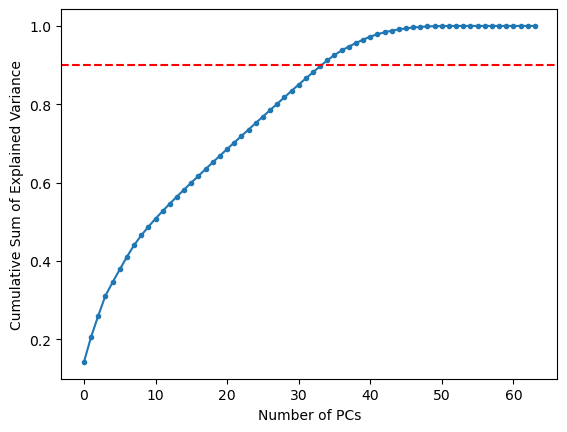

In [41]:
expl_var = my_PCA.explained_variance_ratio_
cumulative_sum = np.cumsum(expl_var)
cumsum_range = np.arange(0, len(cumulative_sum))

# Plot out the cumulative sum graph

plt.figure()
plt.plot(cumsum_range, cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')

plt.show()


 There appears to be an 'elbow' in the plot, which is the point where the rate of increase in explained variance drops significantly. This point is often used to select a reasonable number of components in PCA.

 That's a little bit of a problem: with the elbow starting at variance 0.5 cumulative variance explained.

 Let's see if another form of decomposition works better: Truncated SVD.

 Why Truncated SVD? Beacuse it ususally works better than PCA in sparse matixes. We have a considerable amount of dummy variables mostly 0. Maybe is good in our case.

In [42]:
from sklearn.decomposition import TruncatedSVD


my_tr_svd = TruncatedSVD(n_components=len(X.columns))
my_tr_svd.fit(X_train_scaled)

# transform data 
X_train_tr_svd = my_tr_svd.transform(X_train_scaled)
X_test_tr_svd = my_tr_svd.transform(X_test_scaled)

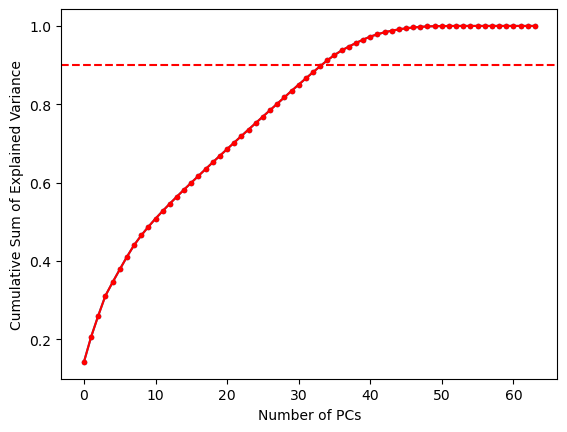

In [43]:
expl_var_svd = my_tr_svd.explained_variance_ratio_
cumulative_sum_svd = np.cumsum(expl_var_svd)
cumsum_range_svd = np.arange(0, len(cumulative_sum_svd))

# Plot out the cumulative sum graph

plt.figure()
plt.plot(cumsum_range, cumulative_sum, marker='.')
plt.plot(cumsum_range_svd, cumulative_sum_svd, marker='.', color='red')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')

plt.show()

The two techniques look almost identical, let's explore further the difference in result

In [45]:
expl_var_svd

array([1.42778071e-01, 6.38263685e-02, 5.42247926e-02, 5.08596637e-02,
       3.41743720e-02, 3.27877500e-02, 3.21941849e-02, 2.97511695e-02,
       2.48378100e-02, 2.21380208e-02, 2.08067137e-02, 1.93557653e-02,
       1.88578898e-02, 1.81974386e-02, 1.77845487e-02, 1.75509224e-02,
       1.73189323e-02, 1.72900437e-02, 1.72346336e-02, 1.69303389e-02,
       1.68808548e-02, 1.67164173e-02, 1.66318072e-02, 1.66137625e-02,
       1.64605947e-02, 1.64006764e-02, 1.63933958e-02, 1.63925176e-02,
       1.63890596e-02, 1.63847938e-02, 1.61637860e-02, 1.57310329e-02,
       1.56768955e-02, 1.54436989e-02, 1.50538352e-02, 1.34290718e-02,
       1.16682618e-02, 9.88106748e-03, 9.14950655e-03, 8.58174021e-03,
       7.82094474e-03, 5.84501747e-03, 5.22297762e-03, 3.99846709e-03,
       3.33576905e-03, 2.76285846e-03, 2.11717524e-03, 1.41285565e-03,
       1.35522521e-03, 5.20052013e-04, 2.79630065e-04, 2.45283364e-04,
       1.08336819e-04, 3.12453097e-05, 1.14859471e-06, 8.06697203e-07,
      

In [46]:
expl_var

array([1.42778071e-01, 6.38263685e-02, 5.42247926e-02, 5.08596637e-02,
       3.41743720e-02, 3.27877500e-02, 3.21941849e-02, 2.97511695e-02,
       2.48378100e-02, 2.21380208e-02, 2.08067137e-02, 1.93557653e-02,
       1.88578898e-02, 1.81974386e-02, 1.77845487e-02, 1.75509224e-02,
       1.73189323e-02, 1.72900437e-02, 1.72346336e-02, 1.69303389e-02,
       1.68808548e-02, 1.67164173e-02, 1.66318072e-02, 1.66137625e-02,
       1.64605947e-02, 1.64006764e-02, 1.63933958e-02, 1.63925176e-02,
       1.63890596e-02, 1.63847938e-02, 1.61637860e-02, 1.57310329e-02,
       1.56768955e-02, 1.54436989e-02, 1.50538352e-02, 1.34290718e-02,
       1.16682618e-02, 9.88106748e-03, 9.14950655e-03, 8.58174021e-03,
       7.82094474e-03, 5.84501747e-03, 5.22297762e-03, 3.99846709e-03,
       3.33576905e-03, 2.76285846e-03, 2.11717524e-03, 1.41285565e-03,
       1.35522521e-03, 5.20052013e-04, 2.79630065e-04, 2.45283364e-04,
       1.08336819e-04, 3.12453097e-05, 1.14859471e-06, 8.06697203e-07,
      

Let's set another PCA and another druncated svd to see how they compare

In [47]:

my_PCA = PCA(n_components=0.8)
my_PCA.fit(X_train_scaled)

# transform data 
X_train_PCA = my_PCA.transform(X_train_scaled)
X_test_PCA = my_PCA.transform(X_test_scaled)



In [48]:
len(my_PCA.explained_variance_ratio_)

28

In [49]:
my_tr_svd = TruncatedSVD(n_components=28)
my_tr_svd.fit(X_train_scaled)

# transform data 
X_train_tr_svd = my_tr_svd.transform(X_train_scaled)
X_test_tr_svd = my_tr_svd.transform(X_test_scaled)

In [50]:
(my_PCA.explained_variance_ratio_ - my_tr_svd.explained_variance_ratio_)


array([-3.10862447e-15,  1.56680224e-12,  1.33850639e-11,  1.88539462e-12,
        1.91632005e-09,  2.75157273e-09,  2.61953785e-09,  8.32649103e-09,
        1.75398266e-08,  2.30052457e-07,  8.32388872e-08,  1.98327342e-06,
        5.73663914e-07,  1.24466170e-06,  3.30831409e-06,  1.92375152e-06,
        5.26931568e-07,  4.43008088e-07,  6.04828332e-08,  1.26942639e-06,
        3.25183483e-06,  2.50899028e-06,  7.67647051e-07,  8.05204944e-06,
        1.28770584e-06,  2.50317949e-06,  3.29978125e-07,  2.26214574e-06])

From these checks we can see that there is no substantial difference.

Conclusion: the two decomposition techniques showed us that:

- Dropping around 30 features will likely have little to no effect on our models
- Dropping around 40 will still let us retain 80% of the variance
- Any more dropping will probably impact  our models



For future sprints: we can actually drop the last components (they don't add anything).

## Experiment 3

How will a simple model without any PCA perform, and without treating class imbalance will work out?

Let's find out with a Linear Regression with arbitrary C.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = df_numerical.drop(columns=['label_red_bin'])

y = df_numerical['label_red_bin']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=33, test_size=0.3)

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
from sklearn.linear_model import LogisticRegression


acc_test = []
acc_train = []

c_range = [1]

for c in c_range:
    logreg = LogisticRegression(C=c, solver='saga', max_iter=1000, n_jobs=-1, verbose=2)
    logreg_fit = logreg.fit(X_train_scaled,y_train)
    acc_train.append(logreg_fit.score(X_train_scaled, y_train))
    acc_test.append(logreg_fit.score(X_test_scaled,y_test))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 1172 seconds


c:\Users\dfuma\anaconda3\envs\cybersec\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 19.5min finished


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = logreg_fit.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-attack", "Predicted Attack"],
    index=["True Non-attack", "True Attack"]
)

display(cf_df)

,Predicted Non-attack,Predicted Attack
True Non-attack,319307,10057
True Attack,42477,63986


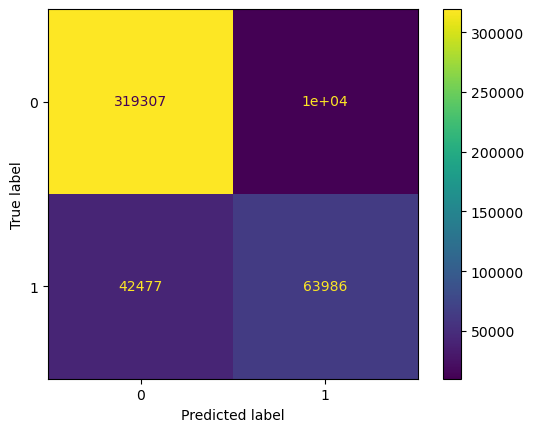

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg_fit, X_test_scaled, y_test)

In [ ]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    329364
           1       0.86      0.60      0.71    106463

    accuracy                           0.88    435827
   macro avg       0.87      0.79      0.82    435827
weighted avg       0.88      0.88      0.87    435827



In [ ]:
import pickle
import sys


model_info = {
    'model': logreg_fit,
    'python_version': sys.version
}

with open('model_with_version.pkl', 'wb') as file:
    pickle.dump(model_info, file)

#TODO CHANGE MODEL FILE NAME

So our logistic regression was both long to run (about 500 minutes) and really bad Recall.

I'm saving the model and move on.

** Conclusion: we need either to change model parameters, change the model itself or change our approach to class imbalance.

### Experiment 4 : "problems with the curve"?

Maybe our linear model just fails to understand patterns on the data. Let's just check this by fitting an SVM with kernel set as rbf.

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the pipeline
pipeline_svc_rbf = Pipeline([
    ('scaler', StandardScaler()),           # Scale the data
    ('svc', SVC(kernel='rbf', C=1, gamma='scale'))  # SVC with RBF kernel
])

# Fit the model on your training data
pipeline_svc_rbf.fit(X_train, y_train)

# You can now use pipeline to make predictions and evaluate the model
y_pred = pipeline_svc_rbf.predict(X_test)

# For evaluation, you can use metrics like accuracy, precision, recall, etc.
# from sklearn.metrics import accuracy_score, classification_report
# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# EXECUTION TIME 700 minutes


In [ ]:
# Assume 'model' is the machine learning model you want to save
model_info_svc_rbf = {
    'model': pipeline_svc_rbf,
    'python_version': sys.version
}

with open('svc_rbf_with_version.pkl', 'wb') as file:
    pickle.dump(model_info_svc_rbf, file)

In [ ]:
# Load the model from the file
with open('svc_rbf_with_version.pkl', 'rb') as file:
    model_info_svc_rbf = pickle.load(file)

# Ensure that the Python version is compatible
import sys
if model_info_svc_rbf['python_version'] != sys.version:
    print("Warning: the model was saved with Python version", model_info_svc_rbf['python_version'], 
          "but you're loading with Python version", sys.version)

# Extract the model from the loaded model_info_svc_rbf
loaded_model = model_info_svc_rbf['model']

# Evaluate the model on test data
y_pred = loaded_model.predict(X_test_tr_svd)

# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)


The output of this model is a 700 minute job with identical performance to our logistic regression. From this perspective at least adding complexity of the model without reworking the data simply doesn't work.

### Experiment 5: Reworking the data

Our previous experiment leads us to believe we should try a different approach: the model needs to be more "sensible" to the attack data.

To do so we'll employ a SMOTE combined with Random Undersampling.

Why? Because here we want to achieve two outcomes: rebalance the data while keeping its size somewhat manageble.

In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Create a pipeline that resamples the data, then applies scaling, dimensionality reduction, and fits a logistic regression model
pipeline = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('under', RandomUnderSampler(sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=30)),
    ('logistic_regression', LogisticRegression(C=1, n_jobs=-1, verbose=2))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s finished


Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.5)),
                ('under', RandomUnderSampler(sampling_strategy=0.8)),
                ('scaler', StandardScaler()),
                ('svd', TruncatedSVD(n_components=30)),
                ('logistic_regression',
                 LogisticRegression(C=1, n_jobs=-1, verbose=2))])

In [ ]:
pipeline.score(X_train)

In [42]:
from sklearn.metrics import accuracy_score

# Evaluate on training data
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Evaluate on test data
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.8078005522514868
Test Accuracy: 0.8093578415288635


In [41]:
# Predict the outcomes on the test set
y_pred = pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.90      0.84      0.87    329364
           1       0.59      0.72      0.65    106463

    accuracy                           0.81    435827
   macro avg       0.75      0.78      0.76    435827
weighted avg       0.83      0.81      0.82    435827



Looking at our first model, we made already a big improvement in recall. However we did loose some precision. Let's try with a linear svm.

In [43]:
from sklearn.svm import LinearSVC

# Define the Linear SVC model
linear_svc = LinearSVC(dual=False, C=1, verbose=2)  # Set dual=False when n_samples > n_features

# Include it in the same pipeline as before
pipeline = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('under', RandomUnderSampler(sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=30)),
    ('linear_svc', linear_svc)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


[LibLinear]              precision    recall  f1-score   support

           0       0.90      0.83      0.86    329364
           1       0.58      0.72      0.64    106463

    accuracy                           0.80    435827
   macro avg       0.74      0.78      0.75    435827
weighted avg       0.82      0.80      0.81    435827



Essentially the same! Not much changed. Maybe we can employ a Naive Bayes? To understand if a gaussian version fits our case, let's make Q-Q plots to check the normality of the distribution.

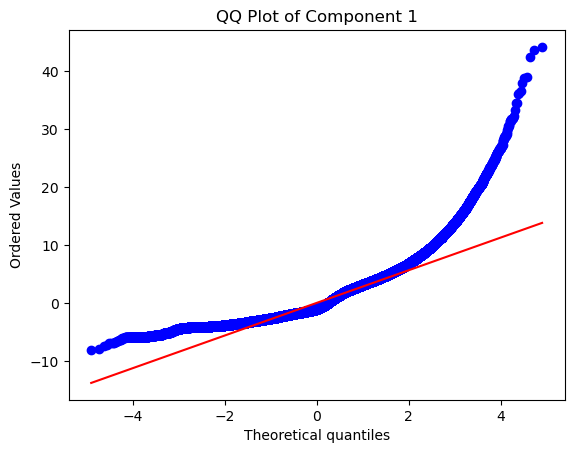

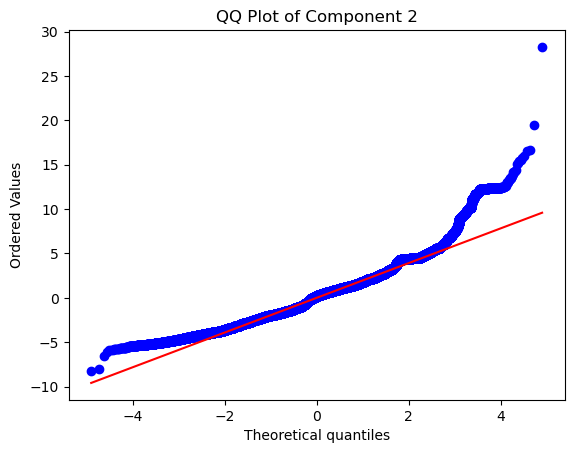

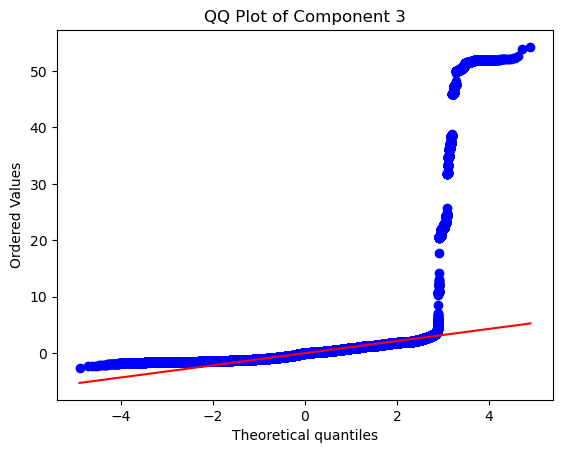

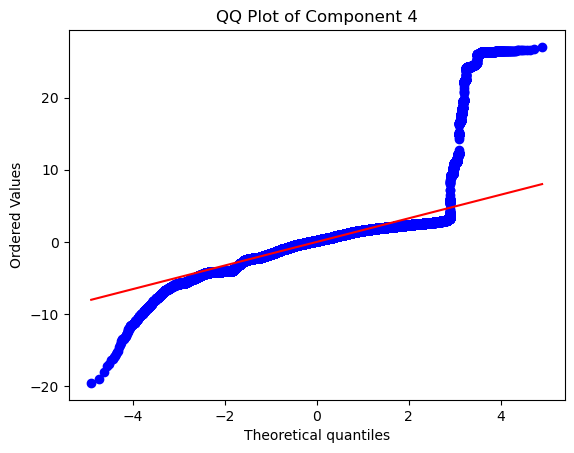

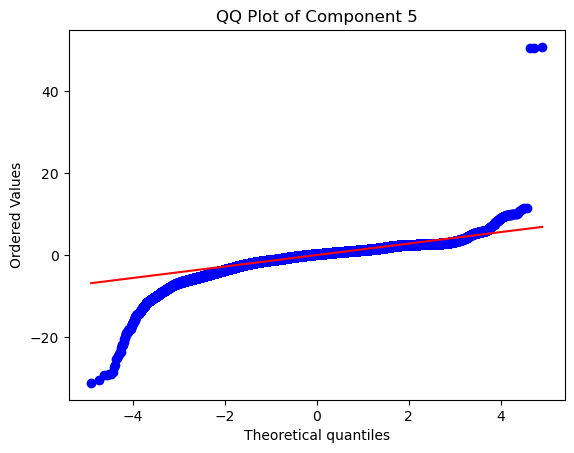

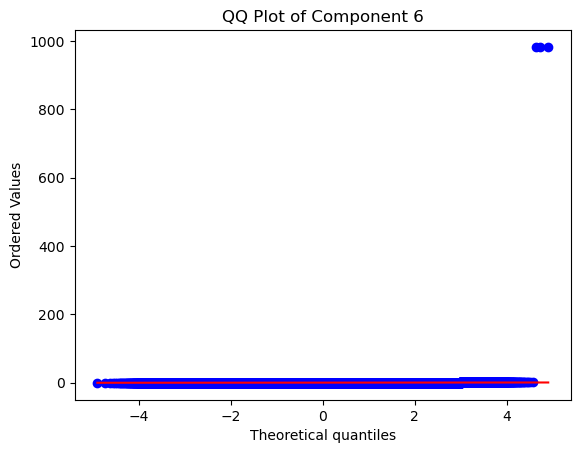

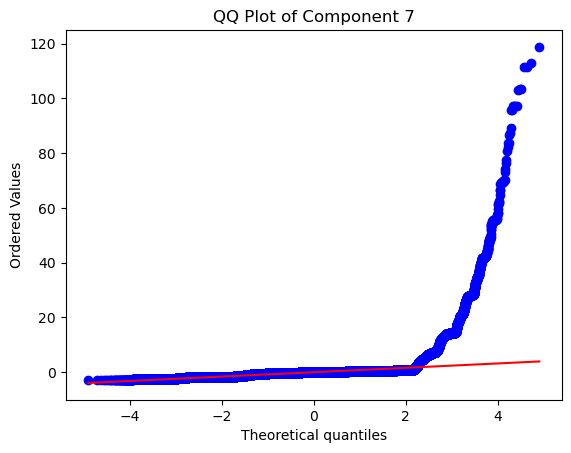

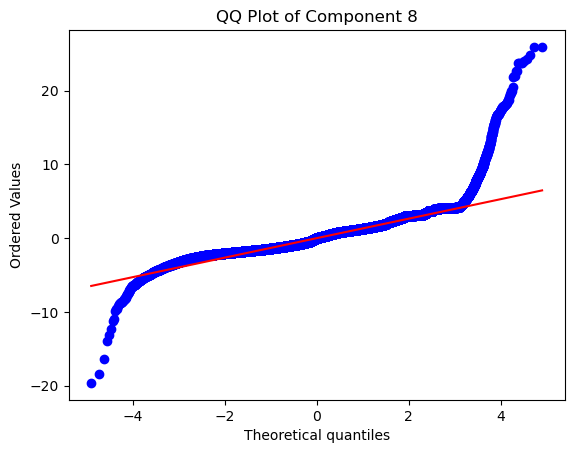

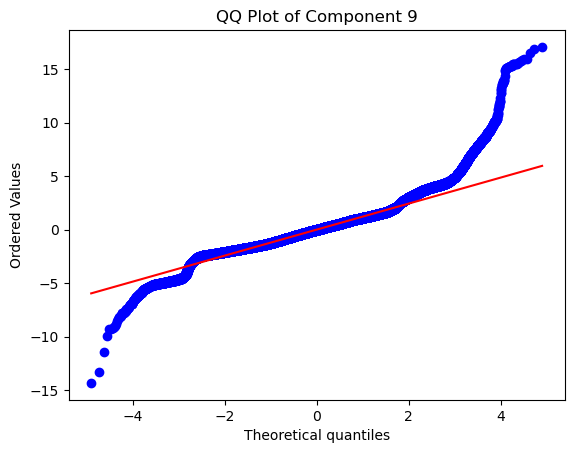

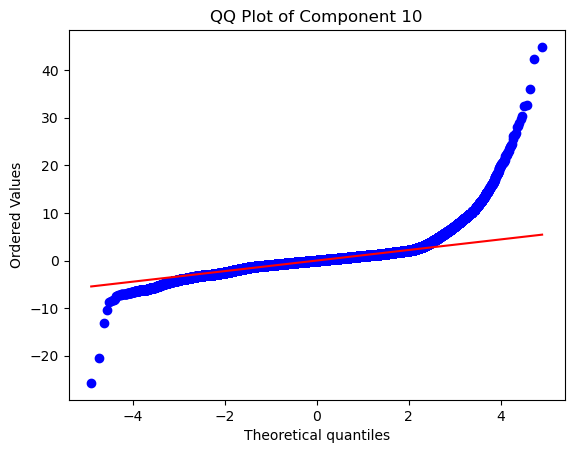

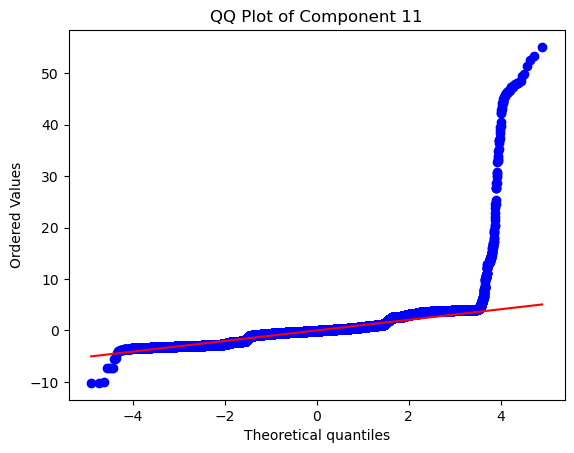

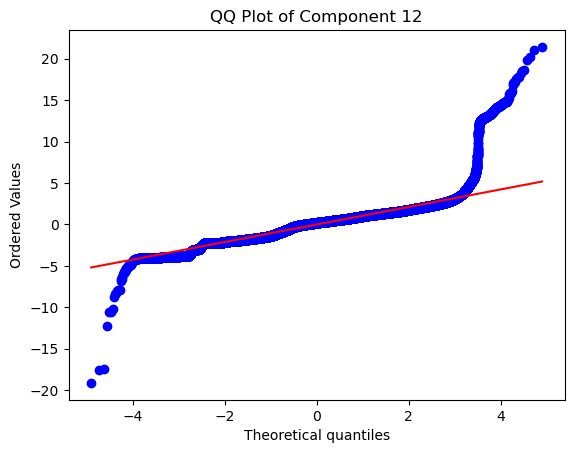

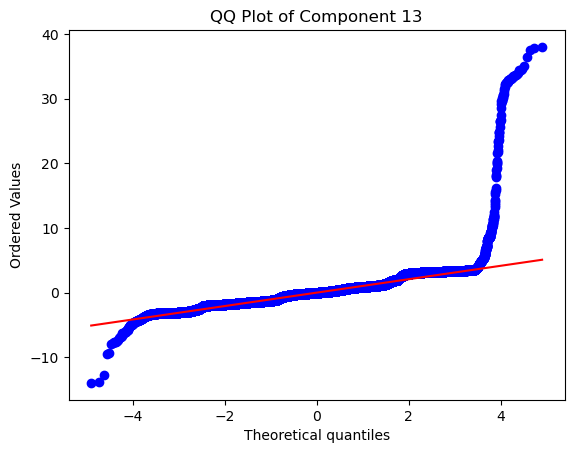

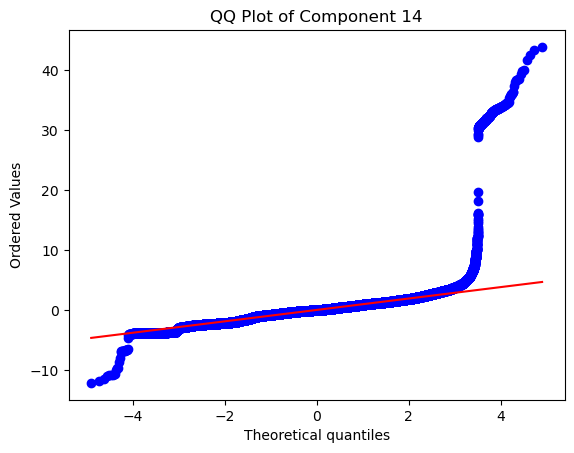

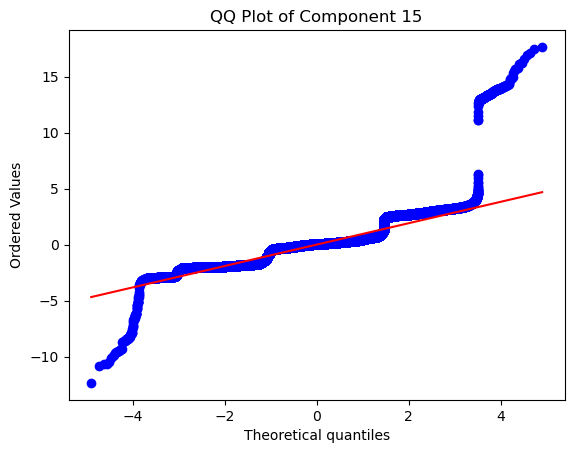

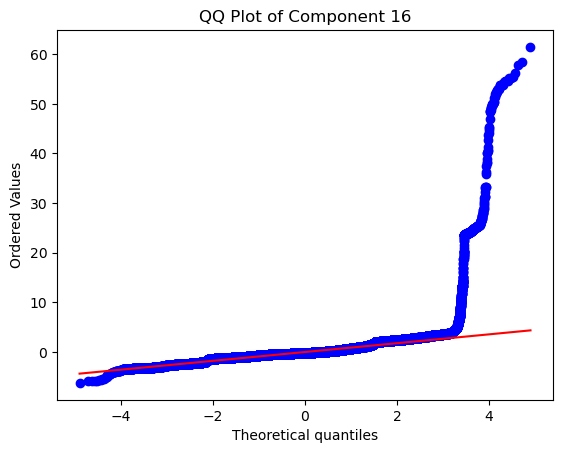

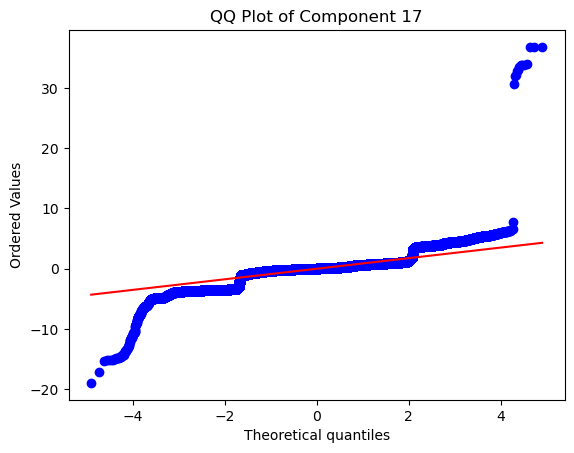

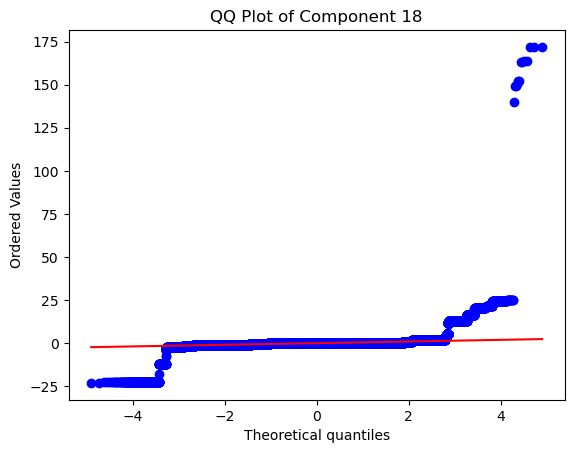

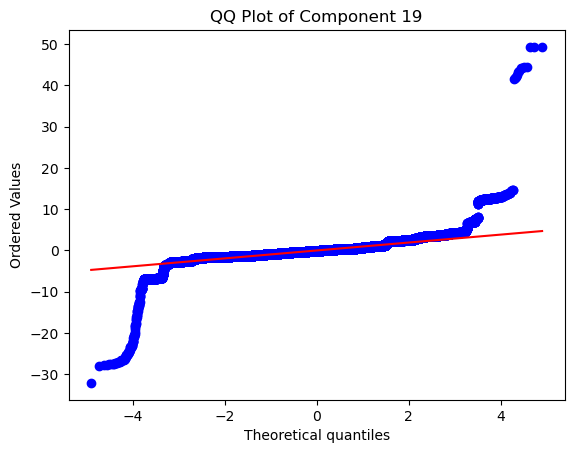

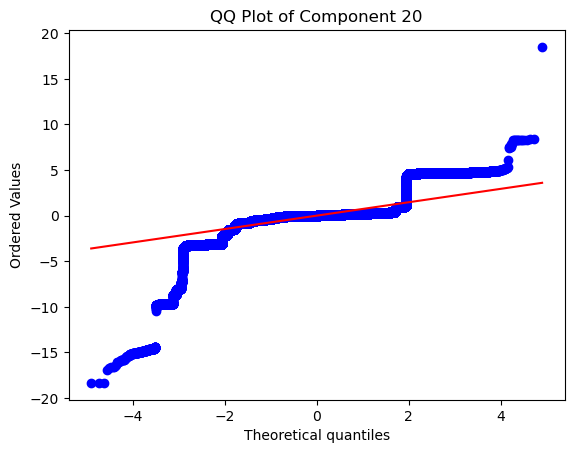

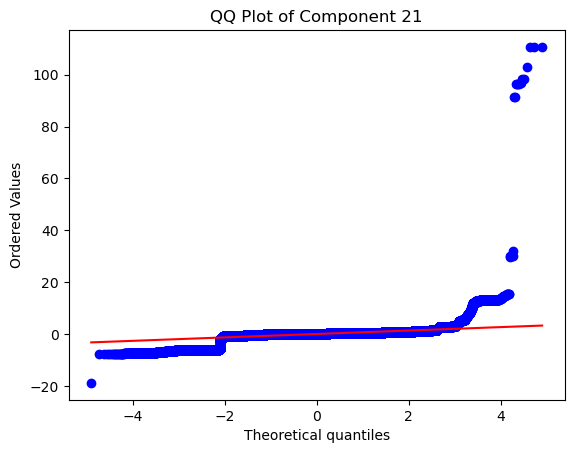

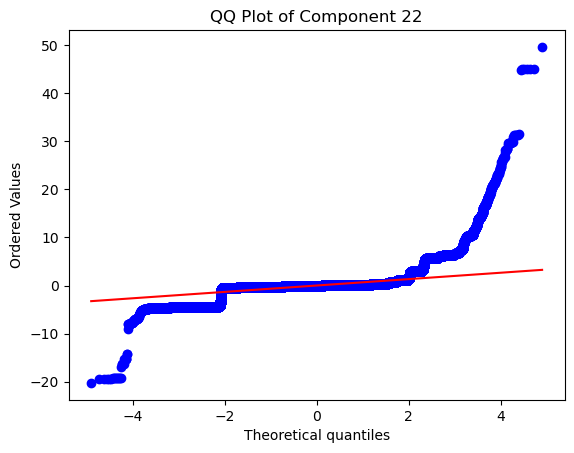

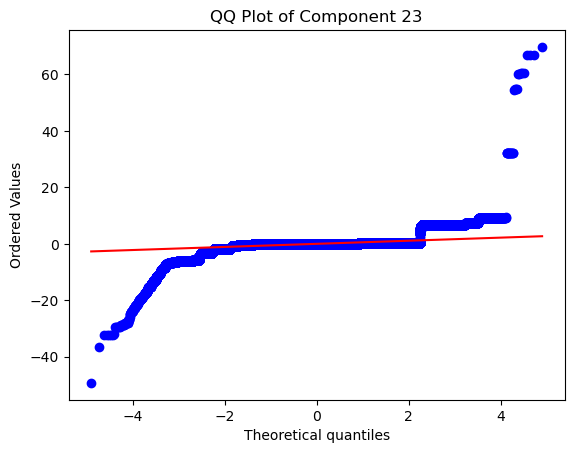

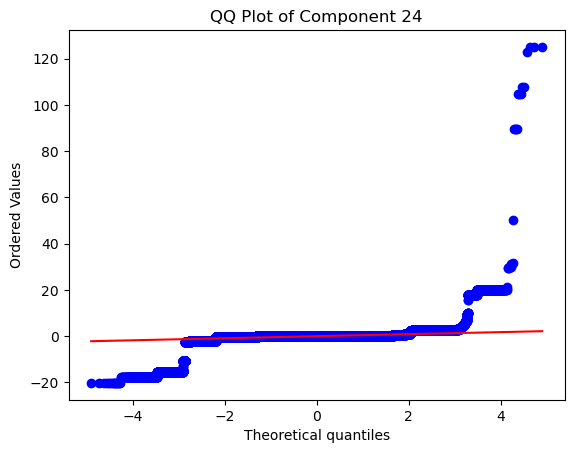

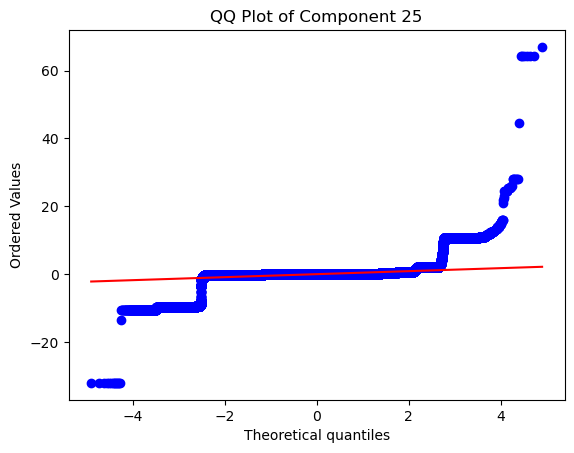

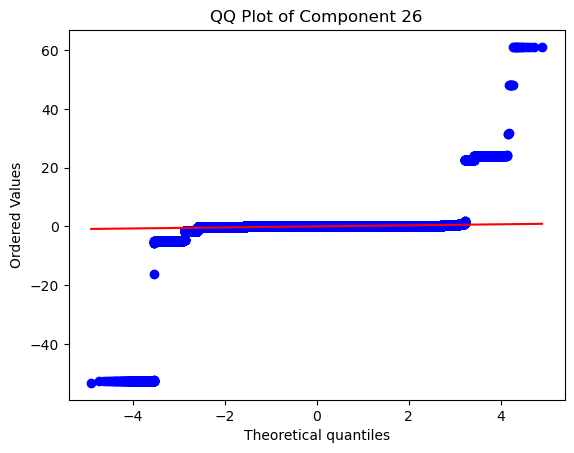

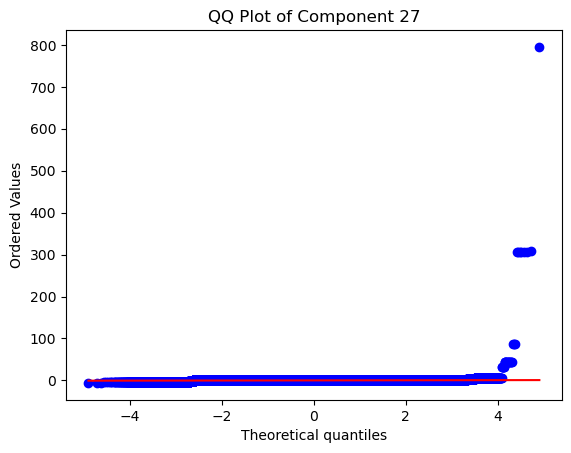

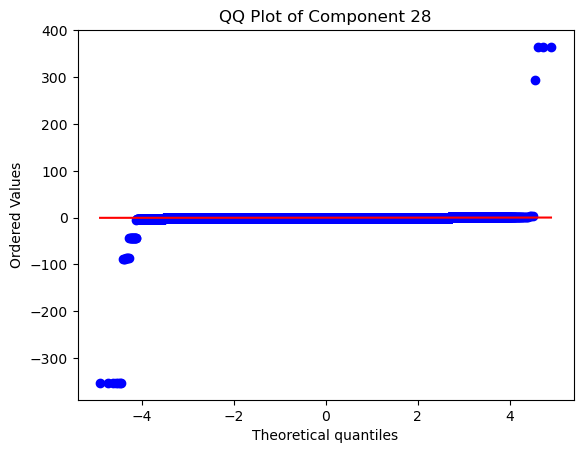

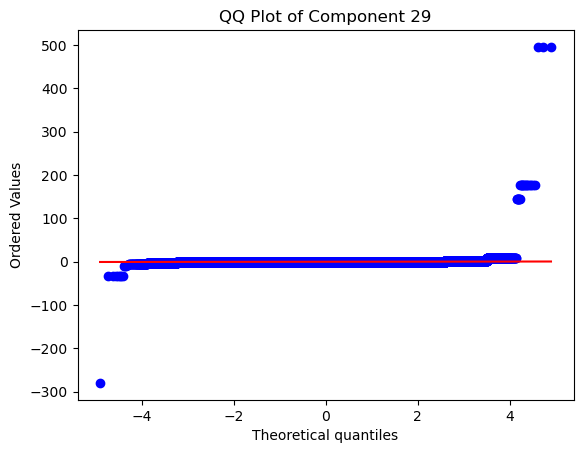

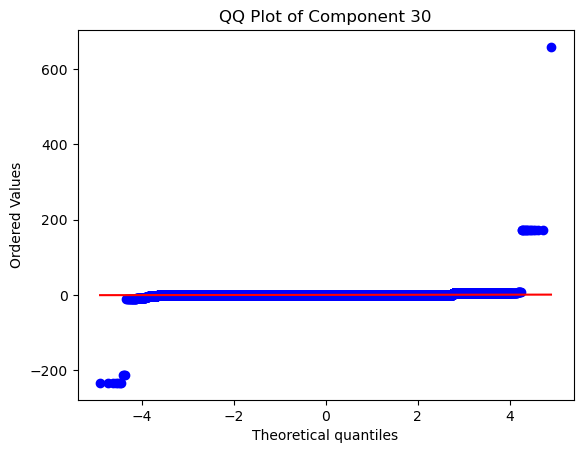

In [48]:

from scipy import stats
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Truncated SVD
svd = TruncatedSVD(n_components=30)
X_reduced = svd.fit_transform(X_scaled)

# Now, create QQ plots for each component
for i in range(X_reduced.shape[1]):
    plt.figure()
    stats.probplot(X_reduced[:, i], dist="norm", plot=plt)
    plt.title(f'QQ Plot of Component {i+1}')
    plt.show()

del X_scaled

In [49]:
del X_reduced

As you can see the components are definetely NOT normally distributed. The way the data is distributed (especially if we think about other parts of the EDA) tells us that maybe a decision tree might be a good choice.

In [51]:

from sklearn.tree import DecisionTreeClassifier


# Define your pipeline
pipeline = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('under', RandomUnderSampler(sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('decision_tree', DecisionTreeClassifier())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = pipeline.predict(X_test)

# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)



              precision    recall  f1-score   support

           0       0.97      0.95      0.96    329364
           1       0.85      0.91      0.88    106463

    accuracy                           0.94    435827
   macro avg       0.91      0.93      0.92    435827
weighted avg       0.94      0.94      0.94    435827



In [56]:
pipeline.score(X_train, y_train)

0.9854119465684886

In [52]:
y_proba = pipeline.predict_proba(X_test)[:,1]

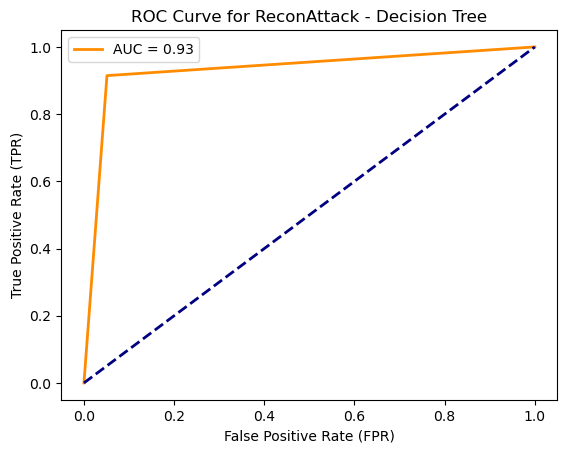

Area under curve (AUC):0.9318010238699834



In [54]:
from sklearn.metrics import roc_curve, roc_auc_score


fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ReconAttack - Decision Tree')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Indeed, it seems a good choice. All values are higher, but we could fine tune it to get better Precision Score.

The high score justifies further efforts in optimization. Let's use again a grid searach cross validation


In [57]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, precision_score


# Define the parameter grid to search
param_grid = {
    'decision_tree__max_depth': [10,  30, 50],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4],
}

# Create a scorer that focuses on precision
precision_scorer = make_scorer(precision_score)

# Create a new pipeline with a decision tree and include the scaler
pipeline = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('under', RandomUnderSampler(sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('decision_tree', DecisionTreeClassifier())
])

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=precision_scorer, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# The best_estimator_ attribute will now be a pipeline with the best combination of parameters
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)

# Print the best combination of parameters
print("Best parameters found: ", grid_search.best_params_)



Best parameters found:  {'decision_tree__max_depth': 30, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 5}


In [59]:
best_tree_report = classification_report(y_test, y_pred)
print(best_tree_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96    329364
           1       0.88      0.91      0.89    106463

    accuracy                           0.95    435827
   macro avg       0.92      0.93      0.93    435827
weighted avg       0.95      0.95      0.95    435827



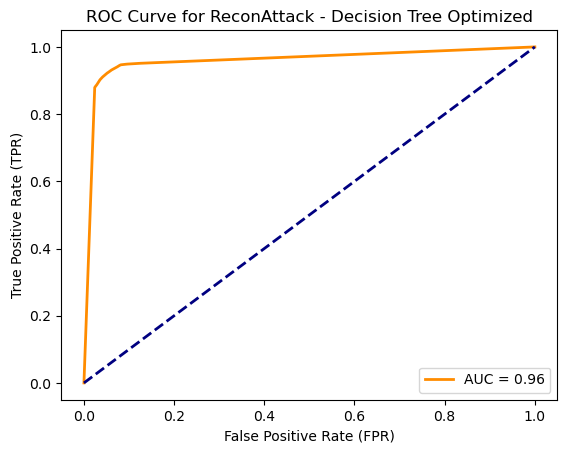

Area under curve (AUC):0.9585123403849007



In [60]:
y_proba = best_model.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ReconAttack - Decision Tree Optimized')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [61]:
best_model

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.5)),
                ('under', RandomUnderSampler(sampling_strategy=0.8)),
                ('scaler', StandardScaler()),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=30, min_samples_leaf=4,
                                        min_samples_split=5))])

To be fair, this model seems to perform very well for our task.
The combination of max depth = 30, min_samples_leaf = 4, min_samples_split = 5 was optimizing for precision.

Vs the unoptimized version we gained 3 points in precsion while not loosing recall. Great result!

# CONCLUSION

- We were able thanks to steps in preprocessing to end up with a pipeline that just make the models better suited for our use case.
- We can further improve the data preprocessing by eliminating some features first as an added step
- Given the nature of the the data, with peaks and extreme values, decision tree was performing well. After all random forest was indeed the model with the highest score in the CICIOT 2023 research as well!
- Now we are in a good position to turn to more complex models and techniques.